### Librerias

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import Row
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Funciones

In [73]:
def table(Columna):
    tabla_frec = pd.crosstab(Columna.fillna("Missing"), columns = "count")
    tabla_frec["COUNT"] = tabla_frec["count"]
    tabla_frec["%_COUNT"] = tabla_frec["count"] / tabla_frec["count"].sum()
    tabla_frec = tabla_frec[["COUNT","%_COUNT"]]
    tabla_frec = tabla_frec.reset_index()
    return tabla_frec

### 3.Adjunto encontrarás una muestra de los archivos de ventas, productos y visitas. ¿Qué información puedes encontrar en ellos?

In [65]:
inventory = pd.read_csv("C:/Users/e10750a/Documents/R5/inventory.csv",sep="\t")
visits = pd.read_csv("C:/Users/e10750a/Documents/R5/visits.csv",sep="\t")
sales = pd.read_json("C:/Users/e10750a/Documents/R5/sales.json")

In [66]:
inventory['precio'] = inventory['precio'].str.slice(1, 5)
inventory['precio']=inventory['precio'].astype(float)
inventory['costo'] = inventory['costo'].str.slice(1, 5)
inventory['costo']=inventory['costo'].astype(float)
inventory['descuento'] = inventory['descuento'].str.slice(1, 5)
inventory['descuento']=inventory['descuento'].astype(float)

visits['date_time'] = visits['date_time'].str.slice(0, 4).astype(str) + visits['date_time'].str.slice(5, 7).astype(str)

sales['Fecha'] = sales['Fecha'].str.slice(6, 10).astype(str) + sales['Fecha'].str.slice(0, 2).astype(str)
sales['valorCompra'] = sales['valorCompra'].str.slice(1, 5)
sales['valorCompra']=sales['valorCompra'].astype(float)

### Data inventory

En la base inventory se puede ver el detalle de las categorías de productos con las que cuenta la compañia para la venta, se observa la Marca del producto, precio, cantidad minima del producto, stock, si es premium o no, costo y descuento. Con esta información podemos observar:
1. Cantidad de producto con el que se cuenta por categoria y por marca
2. Observar la relación precio marca, descuento marca

In [67]:
inventory.head()

,sku,categoria,Marca,precio,cantidad-mínima,stock,premium,costo,descuento
0,MSH20IKO1IE,"Casco, Elementos de proteccion",BMW,68.3,9,13,Yes,63.60,74.0
1,SIH79CER2TM,Pañuelos,Honda,16.7,10,55,Yes,5.04,89.1
2,VBA04IAH4KO,"Casco, Camaras",BMW,71.8,4,57,Yes,44.90,11.8
3,ZEX96BTH9ME,"Guantes, Chaqueta",Other,15.3,6,85,Yes,7.83,18.1
4,DQW58LUO1UQ,NaN,Suzuki,27.4,4,78,No,50.40,91.8


In [71]:
resumen_inventory = inventory.describe().transpose()
resumen_inventory

,count,mean,std,min,25%,50%,75%,max
precio,100.0,51.1192,28.217723,1.09,32.600,49.1,76.825,97.9
cantidad-mínima,100.0,6.0500,2.671870,1.00,4.000,6.0,8.250,10.0
stock,100.0,46.2600,28.066163,0.00,21.000,45.5,69.000,100.0
costo,100.0,46.8998,30.023932,0.33,20.325,45.3,73.550,99.2
descuento,100.0,47.4463,28.930311,2.40,21.100,46.6,71.000,98.2


In [77]:
table(inventory['categoria'])

col_0,categoria,COUNT,%_COUNT
0,Botas,7,0.07
1,"Botas, Camaras",1,0.01
2,"Botas, Chaqueta",1,0.01
3,Camaras,2,0.02
4,"Camaras, Botas",2,0.02
5,"Camaras, Guantes",1,0.01
6,"Camaras, Pañuelos",1,0.01
7,"Camaras, Ropa",1,0.01
8,Casco,3,0.03
9,"Casco, Camaras",2,0.02


In [78]:
table(inventory['Marca'])

col_0,Marca,COUNT,%_COUNT
0,BMW,17,0.17
1,Harley Davidson,12,0.12
2,Honda,19,0.19
3,Other,24,0.24
4,Suzuki,12,0.12
5,Yamaha,16,0.16


### Data Visits

En la base Visits se puede ver el detalle de las visitas al sitio web de la página, cuál fue el medio que se utilizo, tipo de página, tiempo, pais y fecha . Con esta información podemos observar:

1. Fecha con mayores visitas
2. Medio por el cuál se realizan más visitas
3. Relazión tiempo y tipo de página

In [79]:
visits.head()

,date_time,ip,landing_page,quoted,account,source,time_on_page
0,201912,Cambodia,Helmets,True,3ACDEE73-DBA3-EC5D-88FF-FA892351BC33,twitter,82
1,201910,Canada,Mechanics,True,475CBF99-FE11-5727-F816-DAD2C2A3D61C,twitter,115
2,201910,Turks and Caicos Islands,home,False,9030CFE2-A6BC-988F-46D9-B5E8810D010A,instagram,125
3,202005,Kuwait,Mechanics,False,5F51E8B5-EE11-CAB0-79A3-FDC3299E0422,direct,45
4,202008,Saint Lucia,Accesories,True,983CA7D0-5C40-CB71-E42E-618A42B0CADC,instagram,140


In [80]:
resumen_visits = visits.describe().transpose()
resumen_visits

,count,mean,std,min,25%,50%,75%,max
time_on_page,100.0,80.95,44.7517,1.0,41.75,86.5,121.0,159.0


In [84]:
table(visits['landing_page'])

col_0,landing_page,COUNT,%_COUNT
0,Accesories,6,0.06
1,Categories,12,0.12
2,Contact,9,0.09
3,Gloves,12,0.12
4,Helmets,9,0.09
5,Jackets,11,0.11
6,Logos,12,0.12
7,Mechanics,11,0.11
8,Pants,4,0.04
9,Stickers,5,0.05


In [85]:
table(visits['source'])

col_0,source,COUNT,%_COUNT
0,cpc,8,0.08
1,direct,20,0.20
2,email,19,0.19
3,facebook,14,0.14
4,instagram,14,0.14
5,referral,12,0.12
6,twitter,13,0.13


### Data Sales

En la base Sales se puede ver el detalle de las ventas que tuvo la compañia, en que fecha, la forma de pago y el valor de la compra . Con esta información podemos observar:

1. Fechas en las que se realizan mayores ventas
2. Con cuál forma de pago se realizan mayores ventas

In [69]:
sales.head()

,Fecha,account,card_no,formaPago,itemsCount,ldm,paymentId,score,valorCompra
0,202004,5C9951F2-56BD-D7A5-A855-32AECF03B935,5316 7981 7642 3421,other,1,NVL61QQS2BG,0E9D663B-6BAD-D6F4-C8FD-3299101DEBC9,0.465270,424.0
1,201910,3D8EEA8B-2AD1-9466-5168-CFAF0FB3017D,453 99517 27986 479,cash,7,NSE46HXH3JS,A6A97FFF-FAE4-9644-71A5-FFDDF1AE8712,0.197199,43.3
2,202003,B0534D71-B811-9B8A-4CF2-3BDEF145B390,4929489169304115,cash,5,WRZ36RLY7SE,BA2F1F95-A5AE-90EC-5329-92C4380CC138,0.708212,959.0
3,202002,3A68ACAA-E0CE-39C2-15D3-C44390A233C6,4916310716631757,credit,6,EMN20FAX5CI,EA5A493F-2DD9-A6BC-65A8-68816745D9B2,0.596619,966.0
4,201912,585182E5-DF62-847B-0C77-81EB34AEF2AF,None,pse,1,IGL97MFP5LY,00A41F14-F65E-5530-D4F9-4FC97DE049C4,0.605377,332.0


In [49]:
resumen_sales = sales.describe().transpose()
resumen_sales

,count,mean,std,min,25%,50%,75%,max
itemsCount,100.0,4.420000,2.454351,1.000000,2.000000,5.000000,7.000000,8.000000
score,100.0,0.471656,0.226138,-0.093115,0.329714,0.465304,0.598809,0.951717
valorCompra,100.0,498.287300,284.162065,2.100000,273.250000,470.000000,768.500000,966.000000


In [87]:
table(sales['formaPago'])

col_0,formaPago,COUNT,%_COUNT
0,cash,27,0.27
1,credit,30,0.30
2,other,20,0.20
3,pse,23,0.23


### 4.¿Qué tipo de reportes y gráficas harías para comunicar tus conclusiones?

### Data Inventory

Se puede observar que la mayoria de categoria de productos con los que cuenta la empresa no son de una marca en especifico pero que si comparamos las marcas reconocidas hay mayor categorias de productos de BMW, Honda y Yamaha.

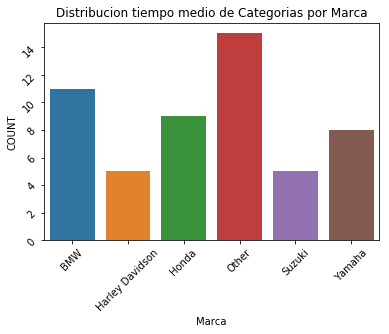

In [125]:
inventory_cat_marc=inventory[['Marca','categoria']]
inventory_cat_marc=inventory_cat_marc.drop_duplicates()
df1=table(inventory_cat_marc['Marca'])
ax = sns.barplot(data=df1, x="Marca", y="COUNT")
ax.set_title("Distribucion tiempo medio de Categorias por Marca")
ax.tick_params(labelrotation=45)
plt.show()

### Detalle por promedio de precios 

En la siguiente tabla podemos observar por categoria de productos:

1. Se puede observar los productos con menor precio. Por ejemplo en botas los productos con menor precio son de marca Honda, en casco y guantes el producto con menor precio son de la marca Suzuki y en Ropa y pañuelos los productos más costosos son de Yamaha.
2. De igual manera se observa una relación uno a uno con precio, costo y descuento . Es decir aumentan o disminuyen.
3. Unja particularidad es que a pesar que dentro de la cvategoria hay productos de marca de menor costo esto no influye en el stoock que se tiene.

In [181]:
grouped = inventory.groupby(['categoria','Marca',]).mean().reset_index()
grouped.sort_values(['categoria','precio'], ascending=True)

,categoria,Marca,precio,cantidad-mínima,stock,costo,descuento
1,Botas,Honda,37.266667,5.666667,55.000000,31.890000,61.733333
2,Botas,Other,43.666667,6.000000,46.333333,16.736667,29.550000
0,Botas,BMW,89.500000,4.000000,18.000000,95.800000,10.500000
3,"Botas, Camaras",BMW,4.940000,4.000000,3.000000,63.000000,24.300000
4,"Botas, Chaqueta",Other,47.100000,3.000000,91.000000,88.500000,12.300000
5,Camaras,Other,6.830000,9.000000,46.000000,17.300000,11.800000
6,Camaras,Yamaha,8.190000,9.000000,42.000000,35.300000,50.500000
7,"Camaras, Botas",Other,22.600000,7.000000,64.000000,74.700000,96.300000
8,"Camaras, Botas",Suzuki,55.000000,10.000000,98.000000,89.900000,64.600000
9,"Camaras, Guantes",Honda,83.100000,9.000000,65.000000,20.700000,61.100000


## Data Visitas

De la data de visitas se puede concluir:
1. El medio por el que se realizan las visitas es independiente en el tiempo en la página
2. Las páginas de destino con mayor tiempo de visita son stikers, home y jackests
3. Aunque el número de visitas no se ha mantenido estable si se puede observar una tendencia creciente.

In [184]:
visits.head()

,date_time,ip,landing_page,quoted,account,source,time_on_page
0,201912,Cambodia,Helmets,True,3ACDEE73-DBA3-EC5D-88FF-FA892351BC33,twitter,82
1,201910,Canada,Mechanics,True,475CBF99-FE11-5727-F816-DAD2C2A3D61C,twitter,115
2,201910,Turks and Caicos Islands,home,False,9030CFE2-A6BC-988F-46D9-B5E8810D010A,instagram,125
3,202005,Kuwait,Mechanics,False,5F51E8B5-EE11-CAB0-79A3-FDC3299E0422,direct,45
4,202008,Saint Lucia,Accesories,True,983CA7D0-5C40-CB71-E42E-618A42B0CADC,instagram,140


([<matplotlib.axis.XTick at 0x115c7780>,
 <a list of 13 Text xticklabel objects>)

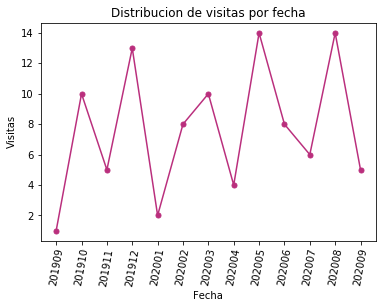

In [254]:
df1= visits.groupby(['date_time']).count().reset_index()
ind = np.arange(len(df1['date_time']))
N = len(ind)
plt.plot(ind, df1['ip'], '-o', color='#ba2f7d', markersize = 5)
plt.ylabel('Visitas')
plt.xlabel('Fecha')
plt.title('Distribucion de visitas por fecha')
plt.xticks(ind, df1['date_time'], rotation=80)

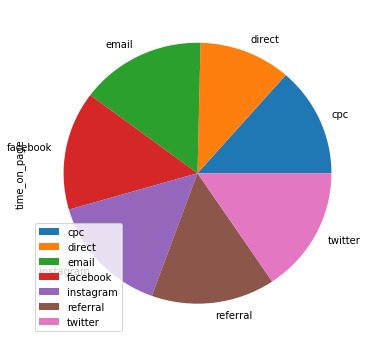

In [217]:
df1 = visits.groupby(['source']).mean().reset_index()
plot = df1.plot.pie(y='time_on_page',labels=df1['source'], figsize=(6, 6))

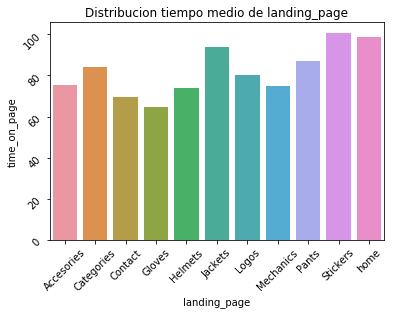

In [221]:
df1 = visits.groupby(['landing_page']).mean().reset_index()
ax = sns.barplot(data=df1, x="landing_page", y="time_on_page")
ax.set_title("Distribucion tiempo medio de landing_page")
ax.tick_params(labelrotation=45)
plt.show()

## Data Sales

De la data de sales se puede concluir:
1. Los ingresos al segundo mes aumentaron significativamente pero apartir de allí han ido disminuyendo.
2. Las formas en que hay más pagos son a crédito y en efectivo.

([<matplotlib.axis.XTick at 0x12919978>,
 <a list of 13 Text xticklabel objects>)

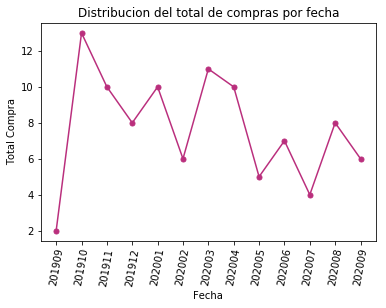

In [265]:
df1= sales.groupby(['Fecha']).count().reset_index()
ind = np.arange(len(df1['Fecha']))
N = len(ind)
plt.plot(ind, df1['valorCompra'], '-o', color='#ba2f7d', markersize = 5)
plt.ylabel('Total Compra')
plt.xlabel('Fecha')
plt.title('Distribucion del total de compras por fecha')
plt.xticks(ind, df1['Fecha'], rotation=80)

In [260]:
df1 =sales.groupby(['formaPago']).count().reset_index()
df1

,formaPago,Fecha,account,card_no,itemsCount,ldm,paymentId,score,valorCompra
0,cash,27,27,27,27,27,27,27,27
1,credit,30,30,29,30,30,30,30,30
2,other,20,20,12,20,20,20,20,20
3,pse,23,23,3,23,23,23,23,23


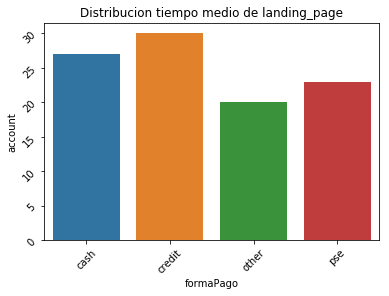

In [262]:
df1 =sales.groupby(['formaPago']).count().reset_index()
ax = sns.barplot(data=df1, x="formaPago", y="account")
ax.set_title("Distribucion tiempo medio de landing_page")
ax.tick_params(labelrotation=45)
plt.show()

# Preguntas Abiertas

### 1. Data wrangling. Crea un script para transformar los siguientes datos 

Data original de ventas:

|Producto|2019|2018|2017|
| --- | --- | ---|---|
|Cascos	|17.000 un.	|15.700 un|	14.301 un|
|Guantes|	8.100 un|	5.400 un|	2.100 un|

Convertir a:

|Producto|Año|Unidades
|---|---|---|
|Cascos|2019|7.000|
|Cascos|2018|15.700|
|Cascos|2017|14.301|
|Guantes|2019|8.100|
|Guantes|2018|5.400|
|Guantes|2017|2.100|

In [ ]:
#Creando el tabla ventas
fila1 = ["Cascos","17.000 un.","15.700 un","14301 un"]
fila2 = [ "Guantes", "8.100 un", "5.400 un", "2.100 un"]
ventas = pd.DataFrame([fila1,fila2], columns = ["producto", "2019", "2018", "2017"])
ventas

In [ ]:
ventas_conv= ventas.melt(id_vars=['producto'], var_name=['Año'])
ventas_conv["value"] = ventas_conv.value.apply(lambda x:x.replace(".","")).str.extract('(\d+)')
ventas_conv

## 2.La tabla session almacena las visitas de los usuarios (autenticados o no) al sitio web:

|Column_name|	Datatype|
|---|---|
|session_id	|autonumeric long|
|start_time	|datetime NOT NULL|
|end_time	|datetime NULL|
|user_id	|long NULL|
|ip	|text|

#### Hacer una consulta en SQL que retorne la lista de usuarios y cuánto tiempo pasó entre su última y penúltima visita

In [ ]:
# Creando ejemplo
f1 = [0,201701, 201712,  90921, "ip1098"]
f2 = [1,201512, 201606, 7654, "ip1098"]
f3 = [2,201604, 201712, 1123, "ip1514"]
f4 = [3,201905, 201908, 1123, "ip9120"]
f5 = [4,201811, 201902 , 7654, "ip1514"]
f6 = [5,201812, 201905 , 90921, "ip1098"]
f7 = [6,201811, 201912 , 7654, "ip1514"]
f8 = [7,202001, 202011 , 1123, "ip9120"]
f9 = [8,201912, 202003 , 7654, "ip9120"]
f10 = [9,202004, 202011 , 90921, "ip1098"]

df = pd.DataFrame([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10], columns = ["session_id", "start_time", "end_time", "user_id", "ip"])
df = spark.createDataFrame(df)
df.show()

In [ ]:
df.createOrReplaceTempView("usuario")
base_1 = spark.sql(""" SELECT A.user_id,  A.start_time, MAX(B.end_time) as max_end_time
                        FROM usuario AS A
                        LEFT JOIN usuario AS B  
                        ON (B.user_id = A.user_id AND 
                        B.end_time < A.start_time)
                        GROUP BY A.user_id,A.start_time
""")
base_1.createOrReplaceTempView("base_1")
spark.sql(""" SELECT A.user_id, A.start_time ,  (cast(substr(start_time, 5, 6) as int) + ((12 * (cast(substr(start_time, 1, 4) as int) - 
                     cast(substr(max_end_time, 1, 4) as int))) - cast(substr(max_end_time, 5, 6) as int))) as dif_meses
                    FROM base_1 AS A
                    
""").show()